In [1]:
import numpy as np

class PCAFromScratch:
    def __init__(self, n_components):
        self.n_components = int(n_components)
        self.mean_ = None                 # (d,)
        self.components_ = None           # (n_components, d) principal axes (rows)
        self.explained_variance_ = None   # (n_components,)
        self.explained_variance_ratio_ = None  # (n_components,)
        self.singular_values_ = None      # (n_components,)
        self.fitted_ = False

    def fit(self, X):
        """
        Center X, compute top n_components principal axes via SVD.
        X: (n_samples, n_features)
        """
        X = np.asarray(X, dtype=float)
        n, d = X.shape
        k = self.n_components if self.n_components <= min(n, d) else min(n, d)

        # 1) center
        self.mean_ = X.mean(axis=0)
        Xc = X - self.mean_

        # 2) SVD of centered data
        # Xc = U S V^T  -> rows of V^T are principal directions
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)

        # 3) keep top k components
        self.components_ = Vt[:k, :]                         # (k, d)
        # explained variance of each PC: S^2 / (n-1)
        var = (S**2) / (n - 1)
        self.explained_variance_ = var[:k]
        self.singular_values_ = S[:k]
        total_var = var.sum()
        self.explained_variance_ratio_ = self.explained_variance_ / total_var if total_var > 0 else np.zeros_like(self.explained_variance_)

        self.n_components = k
        self.fitted_ = True
        return self

    def transform(self, X):
        """
        Project X onto learned principal axes.
        Returns Z of shape (n_samples, n_components)
        """
        if not self.fitted_:
            print("transform: call fit(X) first.")
            return None
        X = np.asarray(X, dtype=float)
        Xc = X - self.mean_
        Z = Xc @ self.components_.T
        return Z

    def checkPCA(self, X):
        """
        Quick sanity checks:
          1) transformed shape is (n_samples, n_components)
          2) components are (approximately) orthonormal
          3) explained variance is non-increasing
        Returns True if all pass, else False.
        """
        if not self.fitted_:
            print("checkPCA: call fit(X) first.")
            return False

        Z = self.transform(X)
        ok_shape = (Z is not None) and (Z.shape[1] == self.n_components)

        # components orthonormal: C C^T ≈ I
        C = self.components_
        I = C @ C.T
        ok_ortho = np.allclose(I, np.eye(self.n_components), atol=1e-6)

        # variance non-increasing
        ev = self.explained_variance_
        ok_monotonic = np.all(ev[:-1] >= ev[1:] - 1e-12)

        return bool(ok_shape and ok_ortho and ok_monotonic)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load digits dataset (8x8 grayscale images, 1797 samples, 64 features)
digits = load_digits()
X, y = digits.data, digits.target
print("Data shape:", X.shape)   

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Data shape: (1797, 64)


In [ ]:

n_components_list = [2, 5, 10, 20, 30, 40, 50, 64]

pca_results = {}
for n in n_components_list:
    pca = PCAFromScratch(n_components=n).fit(X_train)
    Z_train = pca.transform(X_train)
    Z_test = pca.transform(X_test)
    pca_results[n] = {"model": pca, "Z_train": Z_train, "Z_test": Z_test}
    print(f"Done PCA with {n} components → shapes: {Z_train.shape}, {Z_test.shape}")


Done PCA with 2 components → shapes: (1437, 2), (360, 2)
Done PCA with 5 components → shapes: (1437, 5), (360, 5)
Done PCA with 10 components → shapes: (1437, 10), (360, 10)
Done PCA with 20 components → shapes: (1437, 20), (360, 20)
Done PCA with 30 components → shapes: (1437, 30), (360, 30)
Done PCA with 40 components → shapes: (1437, 40), (360, 40)
Done PCA with 50 components → shapes: (1437, 50), (360, 50)
Done PCA with 64 components → shapes: (1437, 64), (360, 64)


In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import numpy as np

k_values = [5, 25, 50, 100]
accuracy_results = {}   # {n_components: {k: accuracy}}

for n in n_components_list:
    Ztr = pca_results[n]["Z_train"]
    Zte = pca_results[n]["Z_test"]
    accuracy_results[n] = {}
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Ztr, y_train)
        y_pred = knn.predict(Zte)
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[n][k] = acc
        print(f"PCA={n:>2} | k={k:>3} → accuracy={acc:.4f}")


PCA= 2 | k=  5 → accuracy=0.6111
PCA= 2 | k= 25 → accuracy=0.6333
PCA= 2 | k= 50 → accuracy=0.6361
PCA= 2 | k=100 → accuracy=0.6250
PCA= 5 | k=  5 → accuracy=0.9278
PCA= 5 | k= 25 → accuracy=0.9194
PCA= 5 | k= 50 → accuracy=0.8861
PCA= 5 | k=100 → accuracy=0.8361
PCA=10 | k=  5 → accuracy=0.9583
PCA=10 | k= 25 → accuracy=0.9417
PCA=10 | k= 50 → accuracy=0.9167
PCA=10 | k=100 → accuracy=0.8972
PCA=20 | k=  5 → accuracy=0.9861
PCA=20 | k= 25 → accuracy=0.9611
PCA=20 | k= 50 → accuracy=0.9333
PCA=20 | k=100 → accuracy=0.9111
PCA=30 | k=  5 → accuracy=0.9806
PCA=30 | k= 25 → accuracy=0.9611
PCA=30 | k= 50 → accuracy=0.9306
PCA=30 | k=100 → accuracy=0.9056
PCA=40 | k=  5 → accuracy=0.9833
PCA=40 | k= 25 → accuracy=0.9583
PCA=40 | k= 50 → accuracy=0.9333
PCA=40 | k=100 → accuracy=0.9111
PCA=50 | k=  5 → accuracy=0.9833
PCA=50 | k= 25 → accuracy=0.9611
PCA=50 | k= 50 → accuracy=0.9333
PCA=50 | k=100 → accuracy=0.9083
PCA=64 | k=  5 → accuracy=0.9833
PCA=64 | k= 25 → accuracy=0.9611
PCA=64 | k

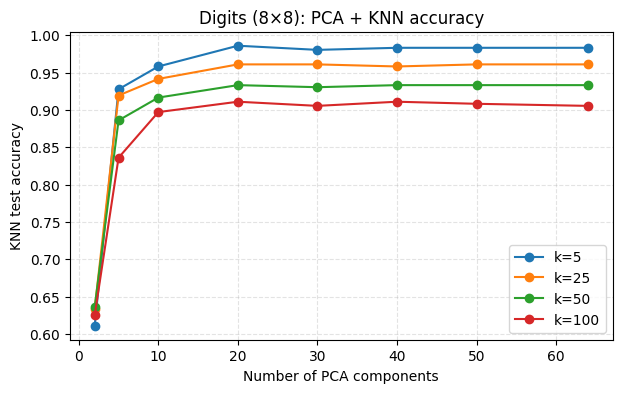

In [ ]:
import matplotlib.pyplot as plt

xs = n_components_list
plt.figure(figsize=(7,4))
for k in k_values:
    ys = [accuracy_results[n][k] for n in xs]
    plt.plot(xs, ys, marker='o', label=f'k={k}')
plt.xlabel("Number of PCA components")
plt.ylabel("KNN test accuracy")
plt.title("Digits (8*8): PCA + KNN accuracy")
plt.grid(alpha=0.35, linestyle='--')
plt.legend()
plt.show()


Applying PCA to reduce dimensionality before classification with KNN shows that only a small number of principal components are needed to achieve high accuracy. The accuracy increases sharply up to about 20 components, after which it stabilizes and remains close to the maximum even with fewer dimensions than the full 64. Among different neighbor values, smaller 𝑘(𝑘 = 5) consistently performs best, while larger 𝑘 values reduce accuracy slightly due to over-smoothing. Overall, PCA is effective in compressing the dataset while preserving discriminative information, and combining it with KNN yields strong classification performance with far fewer features.

The plot shows the classification accuracy of KNN for different numbers of principal components. Accuracy increases sharply as the number of components grows from 2 to about 20, demonstrating that most of the discriminative variance in the digits dataset is captured by a relatively small subset of components. Beyond 20–30 components, the accuracy plateaus, indicating a point of diminishing returns where adding more components does not significantly improve performance.
The choice of k also has a clear influence. Smaller k values (k=5) achieve the highest accuracy, as they preserve fine-grained local information. Larger k values (k=100) smooth over more neighbors, which reduces sensitivity to noise but lowers accuracy. Overall, the results show that PCA enables strong dimensionality reduction without sacrificing accuracy, and that balancing the number of components with the choice of k is key to optimizing KNN performance.